<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Data-cleansing-and-lemmatization" data-toc-modified-id="Data-cleansing-and-lemmatization-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data cleansing and lemmatization</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Wordcloud" data-toc-modified-id="Wordcloud-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Wordcloud</a></span></li><li><span><a href="#Semantic-analysis" data-toc-modified-id="Semantic-analysis-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Semantic analysis</a></span></li><li><span><a href="#Cluster-analysis" data-toc-modified-id="Cluster-analysis-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Cluster analysis</a></span></li></ul></li></ul></div>

# Description
The project is dedicated to analyzing and researching the content of hyperlocal media in VKontakte social media. 

In [1]:
import os
import pandas as pd
import numpy as np
import re
from pymystem3 import Mystem
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram


In [2]:
!pip install WordCloud

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
!pip install Word2Vec

In [5]:
import word2vec
import gensim

In [6]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Data preparation

In [7]:
os.chdir('/Users/evgeniyapolyakova/Desktop/Perm')

In [8]:
# Open data
data = pd.read_csv('publics.csv', on_bad_lines='skip', index_col=0, sep=';' )
pd.set_option('display.max_columns', None)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192860 entries, Пермь_История_Перми to Подслушано_в_Перми
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Url       192860 non-null  object
 1   Likes     192860 non-null  int64 
 2   Reposts   192860 non-null  int64 
 3   Comments  192860 non-null  int64 
 4   Views     192860 non-null  int64 
 5   ER        192860 non-null  object
 6   VR        192860 non-null  object
 7   Text      186464 non-null  object
 8   Date      192860 non-null  object
 9   Author    192860 non-null  object
 10  Media 1   157638 non-null  object
dtypes: int64(4), object(7)
memory usage: 17.7+ MB


### Data cleansing and lemmatization

In [10]:
#columns' name to lowercase,
data.columns = data.columns.str.lower()

In [11]:
#Delete rows with missing text
data.dropna(subset=['text'], inplace=True)
data = data.reset_index(drop=True)

In [12]:
#Check for duplicates
data.duplicated().sum()

3

In [13]:
#Delete duplicates
data.drop_duplicates(subset=None, inplace=True)
data = data.reset_index(drop=True)
data.duplicated().sum()

0

In [14]:
#Text cleaning
def clean_text(text):
    text = re.sub(r'(?:\\n|\\r)', ' ', text)
    text = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text).strip()
    text=text.lower()
    return text

In [15]:
#column with the cleaned text
data['clean_text'] = data['text'].apply(clean_text)

As the analysis involves Russian text, the lemmatization will be performed using the pymystem3 module. This module contains a wrapper for a morphological analyzer for Russian language by Yandex. A morphological analyzer can perform lemmatization of text and derive a set of morphological attributes for each token.

In [16]:
#Text lemmatization
m = Mystem()
def lemmatize(text):
    return " ".join(m.lemmatize(text))

In [17]:
data['lem_text'] = data['clean_text'].apply(lemmatize)
data['lem_text'].dropna(inplace=True)

In [18]:
data['lem_text'].str.replace(r'\b(\w{1,3})\b', '')

0           первомайский   митинг      улица   советский \n
1                                 торговый      ижболдин \n
2         город   молотов       апрель            военны...
3                  отгадывать          ленинский   район \n
4            история   православный   христианский   цер...
                                ...                        
186456                             чернобыльский   ворон \n
186457          знать          викторианский   эпоха   с...
186458       россия   зарегистрировать   первый         ...
186459                            актуально      сегодня \n
186460       день         выхлопать   хата      грабител...
Name: lem_text, Length: 186461, dtype: object

In [19]:
data

,url,likes,reposts,comments,views,er,vr,text,date,author,media 1,clean_text,lem_text
0,https://vk.com/wall-181806850_34356,153,16,4,5269,"0,7397","22,5277",Первомайский митинг на улице Советской,30.03.2023,public181806850,image,первомайский митинг на улице советской,первомайский митинг на улица советский \n
1,https://vk.com/wall-181806850_34353,154,12,11,5226,"0,7568","22,3438",Торговый дома Ижболдиных,30.03.2023,public181806850,image,торговый дома ижболдиных,торговый дом ижболдин \n
2,https://vk.com/wall-181806850_34350,66,0,2,4030,"0,2907","17,2303",Город Молотов. 15 апреля 1944 года. Военно-вра...,30.03.2023,id32702767,image,город молотов апреля года военно вра...,город молотов апрель год вое...
3,https://vk.com/wall-181806850_34337,49,3,22,4222,"0,3164","18,0512",Отгадайте где это? Ленинский район,30.03.2023,id43655525,image,отгадайте где это ленинский район,отгадывать где это ленинский район \n
4,https://vk.com/wall-181806850_34332,48,6,2,1874,"0,2394","8,0123",Из истории Православной Христианской церкви в ...,30.03.2023,id181791068,image,из истории православной христианской церкви в ...,из история православный христианский ц...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186456,https://vk.com/wall-58392407_320265,16,1,1,1592,"0,0317","2,8072",Чернобыльский ворон😁,01.04.2021,public58392407,image,чернобыльский ворон,чернобыльский ворон \n
186457,https://vk.com/wall-58392407_320261,9,4,1,2210,"0,0247","3,8969","А вы знали, что в викторианскую эпоху существо...",01.04.2021,public58392407,image,а вы знали что в викторианскую эпоху существо...,а вы знать что в викторианский эп...
186458,https://vk.com/wall-58392407_320253,0,0,2,1187,"0,0035","2,093",В России зарегистрировали первую в мире вакцин...,01.04.2021,public58392407,NaN,в россии зарегистрировали первую в мире вакцин...,в россия зарегистрировать первый в м...
186459,https://vk.com/wall-58392407_320245,11,6,1,2805,"0,0317","4,946",Актуально на сегодня😂,01.04.2021,public58392407,image,актуально на сегодня,актуально на сегодня \n


In [20]:
#new variable
text = ' '.join(data['lem_text'])

In [21]:
stopwords = stopwords.words("russian")
stopwords.extend(['весь', 'который'])                           

## Analysis

### Wordcloud

In [22]:
text_tokens = word_tokenize(text)
text_tokens = [token.strip() for token in text_tokens if token not in stopwords]
text_wordcloud = nltk.Text(text_tokens)
text_wordcloud = " ".join(text_wordcloud)

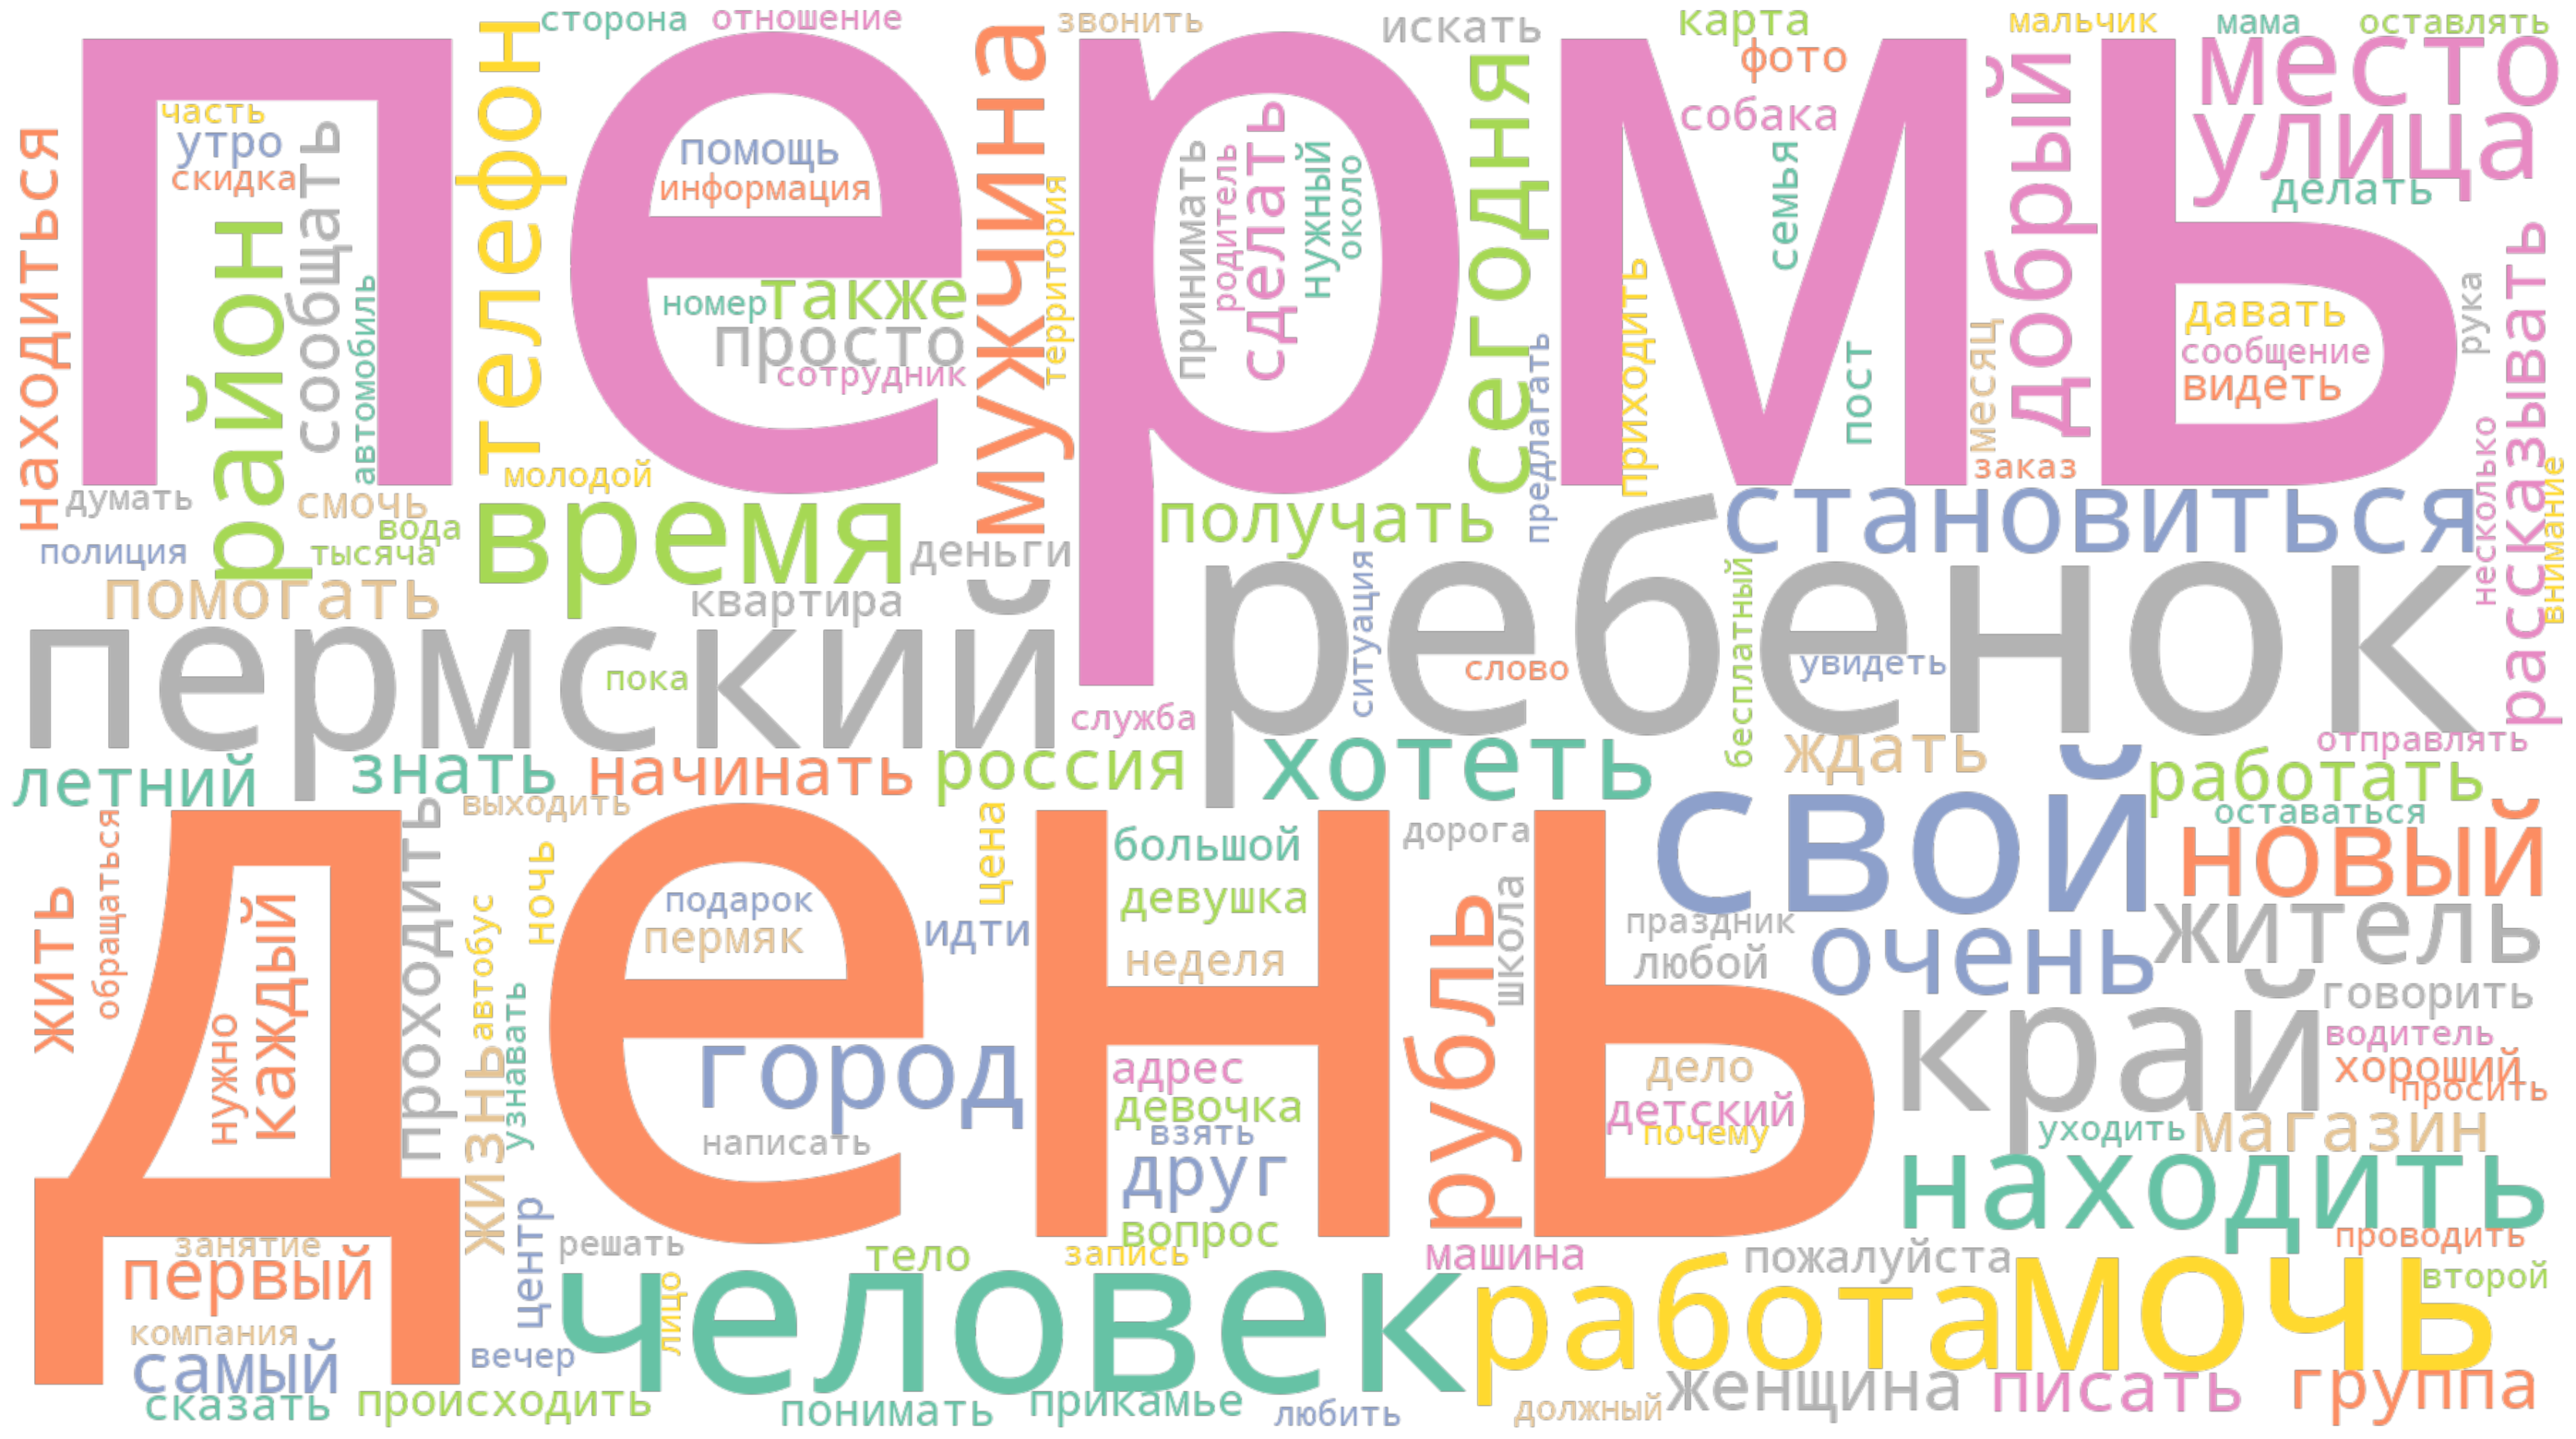

In [23]:
wordcloud = WordCloud(
    min_word_length=4,
    collocations=False,
    mode="RGBA",
    background_color=None,
    width=1800,
    height=1000,
    max_words=150,
    relative_scaling=0.5,
    colormap=("Set2"),
    contour_width=3,
    contour_color="black",
).generate(text_wordcloud)
plt.figure(figsize=(50, 20))
plt.imshow(wordcloud, interpolation="quadric")
plt.axis("off")
plt.show()

The word cloud allows for preliminary assessments of popular topics discussed in hyperlocal media. In addition to obvious words like the city and region's names, frequently used terms include 'work,' 'price', 'Ruble', and 'money.' This indicates discussions of economic issues such as job searches and price hikes. However, there are also distinct terms like 'school,' 'child,' and 'family,' which reflect an interest in topics related to education, family, and the social sphere.

### Semantic analysis

In [24]:
#convert data to txt format for the analysis
data['lem_text'].to_csv('text.txt', sep=" ", index=False)

In [25]:
#building the model
word2vec.word2phrase('text.txt',
                     'text.txt-phrases', verbose=True)


word2vec.word2vec('text.txt-phrases', 
                  'text.txt.bin', verbose=True, alpha=0.003, size=150,  min_count=300) 

model = gensim.models.KeyedVectors.load_word2vec_format( 
    'text.txt.bin', unicode_errors='ignore')


Running command: word2phrase -train text.txt -output text.txt-phrases -min-count 5 -threshold 100 -debug 2
Starting training using file text.txt
Words processed: 10100K     Vocab size: 2143K  
Vocab size (unigrams + bigrams): 1234807
Words in train file: 10168091
Running command: word2vec -train text.txt-phrases -output text.txt.bin -size 150 -window 5 -sample 1e-3 -hs 0 -negative 5 -threads 12 -iter 5 -min-count 300 -alpha 0.003 -debug 2 -binary 0 -cbow 1
Starting training using file text.txt-phrases
Vocab size: 2950
Words in train file: 7748030
Alpha: 0.000001  Progress: 100.00%  Words/thread/sec: 155.10k  

In [26]:
#saving the result of semantic analysis in separate file
file = open('perm.txt', 'w')
                                                        
for i in model.most_similar(positive=['пермь'], topn=100):
    file.write(str(i))
    file.write(' ')
file.close()

### Cluster analysis

In [27]:
#data
corpus=data['lem_text']
corpus=corpus.str.replace(r'\b\w{1,3}\b', '')

In [28]:
#Vectorization
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(corpus)

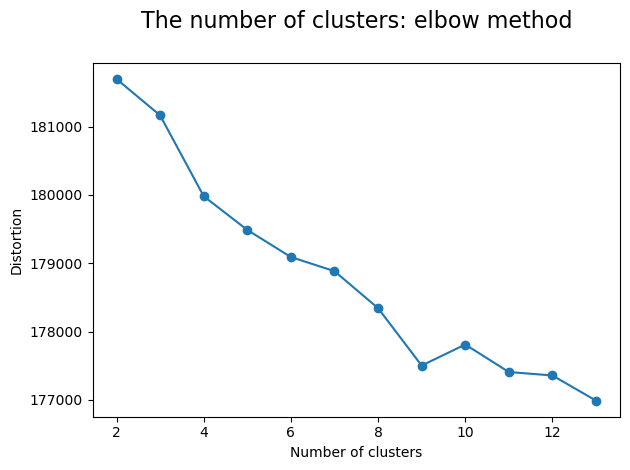

In [29]:
#The optimal number of clusters
distortions = []
for i in range(2, 14):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                random_state=12345)
    km.fit(X)
    distortions.append(km.inertia_)
plt.title("The number of clusters: elbow method\n",fontsize=16)
plt.plot(range(2, 14), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

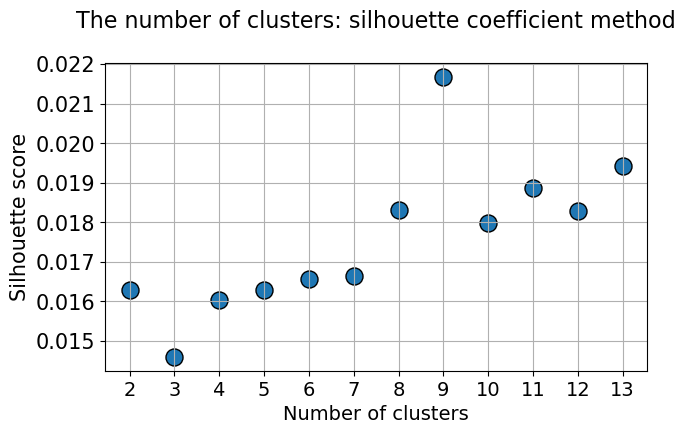

In [30]:
km_silhouette = []
for i in range(2,14):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                random_state=12345)
    km.fit(X)
    preds = km.predict(X)
    silhouette = silhouette_score(X,preds)
    km_silhouette.append(silhouette)

plt.figure(figsize=(7,4))
plt.title("The number of clusters: silhouette coefficient method\n",fontsize=16)
plt.scatter(x=[i for i in range(2,14)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,14)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()    

In [31]:
km = KMeans(n_clusters=9, init='k-means++',random_state=12345)
y=km.fit(X)

In [32]:
#Check the top-20 words in each cluster in new document
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(9):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: пермский
 край
 градус
 житель
 прикамье
 регион
 день
 ожидаться
 температура
 сообщать
 воздух
 человек
 место
 пермь
 ночь
 летний
 погибать
 губернатор
 район
 рассказывать
Cluster 1: пост
 анонимный
 приложение
 отправлять
 полезный
 свой
 хотеть
 женщина
 ипать
 человек
 мужчина
 мужик
 овер
 мочь
 жизнь
 любить
 секс
 группа
 почему
 день
Cluster 2: пермь
 город
 улица
 район
 плохиеновостипермь
 день
 работа
 происходить
 сообщать
 рубль
 пермский
 место
 летний
 житель
 центр
 автобус
 мужчина
 новый
 время
 водитель
Cluster 3: удалять
 запись
 админ
 рекомендовать
 ипать
 завтра
 абонемент
 налимиха
 массаж
 урал
 итог
 собрание
 розыгрыш
 вконтакте
 состояться
 август
 сосед
 обращаться
 группа
 керченский
Cluster 4: утро
 добрый
 погода
 сегодня
 пермь
 настраиваться
 будний
 юмор
 паблик
 слушать
 хороший
 новость
 вконтакте
 день
 пермяк
 ночь
 облачно
 снег
 дождь
 пасмурно
Cluster 5: фотомотовилиха
 фотосадовый
 фотовышка
 мотовилиха
 к